# SARIMA Tahmini

## 01 - Arka Plan

Bu zorlukta amacımız, zaman serisi analizinin temel kavramlarını tek boyutlu verilere (tarihe bağlı satışlar) uygulamaktır.

Bu zorlukta aşağıdaki adımları takip edeceğiz:
1. verileri yükle ve görselleştir;
2. modellerimizi eğit ve tahminler yap;
3. seriyi modellemek ve tahmin edebilmek için ekonometrik bir yaklaşım kullan;
4. bu modeli hacklemek için Makine Öğrenmesi kullan.

Veri seti [Machine Learning Mastery](https://github.com/jbrownlee/) tarafından sağlanmıştır. İndirmek için aşağıdaki satırı çalıştırın!

In [1]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv > data/monthly_champagne_sales.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1596  100  1596    0     0   4199      0 --:--:-- --:--:-- --:--:--  4200


## 02 - Veri Yükleme
Meydan okumanın zaman serisini yükleyerek başlayalım

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/monthly_champagne_sales.csv")
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


👉 DataFrame'in "Month" sütununu `Datetime` nesnelerine dönüştürün ve şu şekilde görünmesi için indeks olarak ayarlayın:
<br>

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/monthly_champagne_sales_objective.png" width=180>

In [3]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [4]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


### Alternatif - Pandas'ın İşi Yapmasına İzin Ver

In [ ]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')
df.head()

## 04 - Veriyi Görselleştir ve Yorumla

Aferin, bu yeniden indeksleme sayesinde artık "Sales" (y-ekseni) değerlerini zamanın (x-ekseni) bir fonksiyonu olarak kolayca çizebilmelisiniz

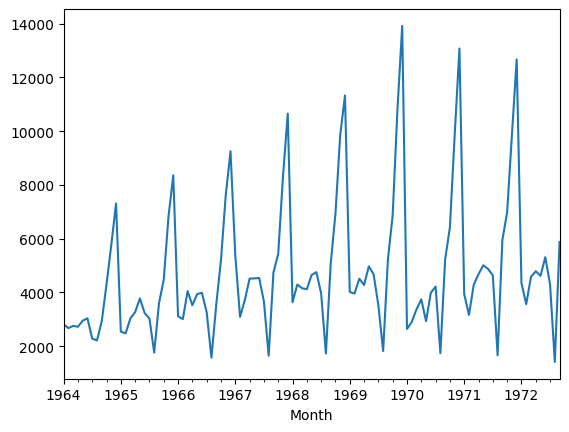

In [5]:
df["Sales"].plot();

Kodunuz doğruysa, bu zaman serisinin (TS) şu özelliklere sahip olduğunu görebilmelisiniz:
- Durağan değil (ortalama ve varyans sabit değil).
- Güçlü mevsimsellik sergiliyor.
- Bir trend var gibi görünüyor.

Verilerin **trend**, **mevsimsellik** ve **gürültü** arasındaki ayrışımını görelim. Bunun için statsmodels'ın [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) fonksiyonunu kullanmalısınız. Dokümanları okuyun ve bu fonksiyonun ne yaptığını ve nasıl kullanıldığını anladığınızdan emin olun, ardından:
1. "Sales"i "additive" model ile çizin
2. "Sales"i "multiplicative" model ile çizin

Profesyonel ipuçları: çift çizim sorunlarını önlemek için statsmodels plot metot çağrılarınızı noktalı virgülle (`;`) bitirin!

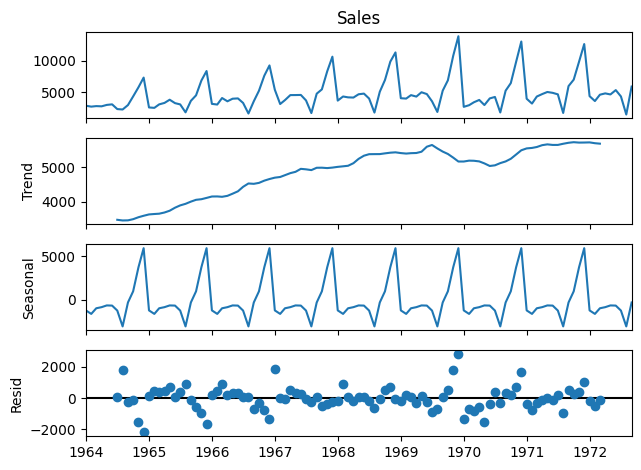

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Additive model ile ayrıştırma
result_add = seasonal_decompose(df["Sales"], model="additive")
result_add.plot();

👉 Seçtiğiniz ayrışımı kullanarak bu zaman serisini mevsimsellikten arındırın

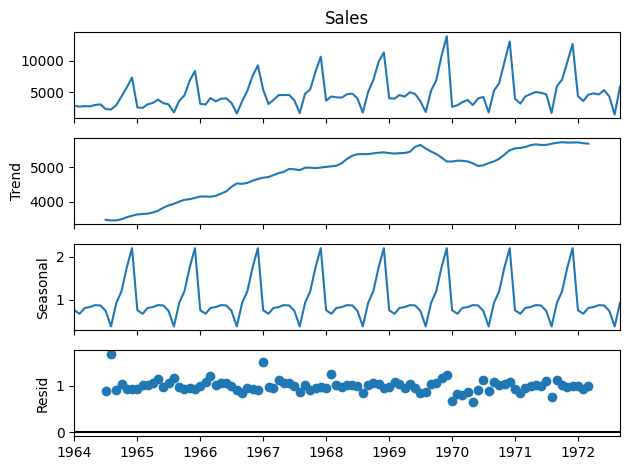

In [7]:
# 2. Multiplicative model ile ayrıştırma
result_mul = seasonal_decompose(df["Sales"], model="multiplicative")
result_mul.plot();

☝️ Bu zaman serisinin "mevsimsellikten arındırılmış" versiyonuna bir ARIMA modeli uydurabilir ve tahminimizden sonra tekrar birleştirebiliriz. Ancak bu meydan okumada, orijinal zaman serisine _doğrudan_ uydurmak için SARIMA modellerini kullanacağız!

## 05 - Veriyi Böl (eğitim/test)


Zaman serileri için test setinde bulunacak noktaları rastgele örnekleyemeyiz. Test setinin "zaman-dışı" olması gerekir, yani test setinin kesinlikle geleceğinde olmalıdır. Bu egzersiz için eğitim için 1970'e kadar olan verileri kullanacağız ve bundan sonraki her şey test için kullanılacak.

👉 `df_train` ve `df_test` oluşturun, DataFrame'i eğitim için 1970 öncesinde ve test için sonrasında (veya eşit) bölerek

In [8]:
df_train = df[df.index < "1970"]
df_test = df[df.index >= "1970"]

print(f"Eğitim seti boyutu: {len(df_train)}")
print(f"Test seti boyutu: {len(df_test)}")

Eğitim seti boyutu: 72
Test seti boyutu: 33


## 06 - SARIMA
Veriyi SARIMA modeli (Seasonal Auto-Regressive Integrated Moving Average - Mevsimsel Oto-Regresif Entegre Hareketli Ortalama) kullanarak analiz edeceğiz.


Yapmamız gerekenler:
- zaman serisini nasıl durağanlaştıracağımızı bul (SARIMA'daki I)
- oto-regresif (AR) kısmını bul
- hareketli ortalama (MA) kısmını bul
- mevsimselliği (S) bul

### Adım 1: Durağanlığı Kontrol Et

Bir zaman serisinin trend veya mevsimsellik bileşeni varsa, tahmin için ARIMA kullanabilmek için önce durağan hale getirilmelidir.

Yukarıdaki grafiğe bir bakış, zaman serisinin durağan olmadığına sizi ikna etmeye yeterli olmalıdır.

[`Augmented Dick Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) ve özellikle p-değerini kullanarak `df["Sales"]`ın durağanlığını tekrar kontrol edin

In [9]:
from statsmodels.tsa.stattools import adfuller

# ADF testini sales sütunu üzerinde çalıştırdım
result = adfuller(df["Sales"])

print(f"ADF İstatistiği: {result[0]}")
print(f"p-değeri: {result[1]}")

ADF İstatistiği: -1.8335930563276215
p-değeri: 0.36391577166024586


Durağanlıkta %95 güvene sahip olmak için p-değeri 0.05'ten küçük olmalıdır.

Eğer p-değeri 0.05'ten büyükse, null hipotezi reddedemeyiz (null hipotez = "süreç durağan değildir").

İdeal olarak, p 0.05'ten *çok* küçük olmalıdır.

Durağanlığı aramanın başka bir yolu otokorelasyon fonksiyonuna (ACF) bakmaktır.

Zaman serisinin ACF'sini çizin. Lag 12'de büyük bir pik görmelisiniz, bu güçlü yıllık mevsimselliği gösterir.

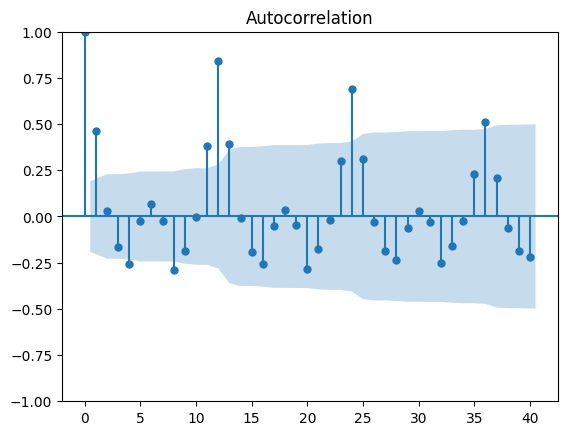

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

# Otokorelasyon grafiği
plot_acf(df["Sales"], lags=40);

### Adım 2 - Mevsimsel Farklaştırma (D)

12 aylık periyodla güçlü bir mevsimselliğimiz var.

Zaman serisi üzerinde **lag 12'nin mevsimsel farklaştırmasını** yapın, farklaştırılmış veriyi çizin ve ACF grafiğini (+ADF testi) tekrar kontrol edin.

NaN'ları düşürmeyi unutmayın.

Yeni p-değeri: 2.0605796968136632e-11


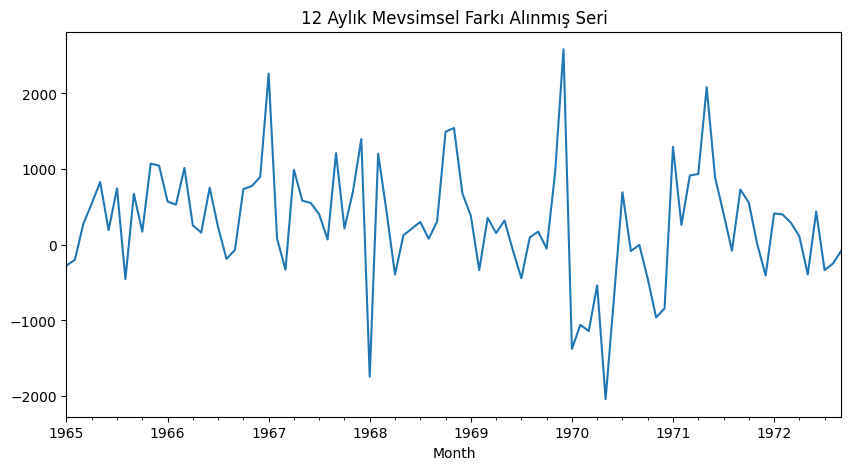

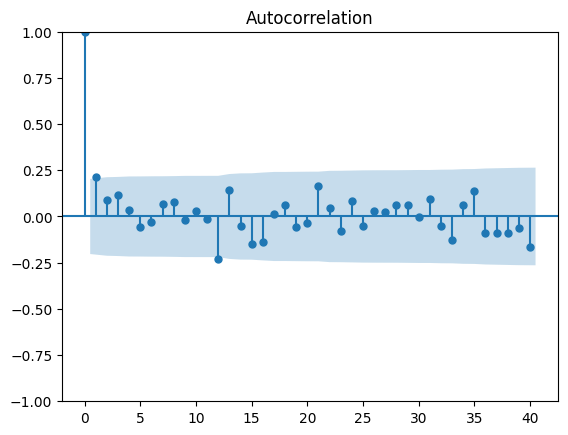

In [ ]:
# 1. 12 aylık mevsimsel farkı
# .diff(12) her satırdan 12 satır öncesini çıkarır
df_diff = df['Sales'].diff(12).dropna()

# 2. Farkı alınmış veriyi çizdim
df_diff.plot(figsize=(10, 5), title="12 Aylık Mevsimsel Farkı Alınmış Seri");

# 3. ACF ve ADF testini tekrar yapıyoruz
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

plot_acf(df_diff, lags=40);
print(f"Yeni p-değeri: {adfuller(df_diff)[1]}")

☝️ TS'yi durağanlaştırmak için tek bir mevsimsel farklaştırma yeterli görünüyor.
SARIMA(p,d,q, P,D,Q,m) için D=1 (1 mevsimsel fark) ve m=12 (mevsimsellik = 12)

### Adım 3 - Farklaştırma (d)

Zaman serisi hala durağan değilse, *farklaştırma* yoluyla durağanlaştırılması gerekir. Bu, her değer ile bir önceki arasındaki farkı almak (*birinci fark*) anlamına gelir.

Mevsimselliği çıkardıktan sonra daha fazla farklaştırmaya ihtiyacımız var mı?

diff(12) seriniz üzerinde ek bir birinci derece diff(1) çalıştırdıktan sonra ACF ve ADF'yi kontrol edin.

Ek fark sonrası p-değeri: 0.0002650462849293455


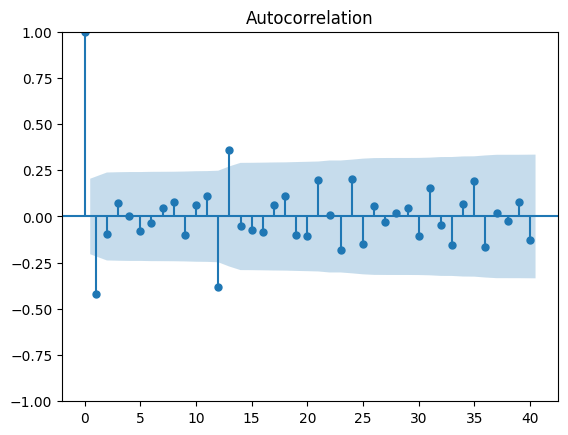

In [12]:
# 1. Mevsimsel farkı alınmış seriye bir de birinci derece fark (diff(1)) ekledim
df_diff_2 = df_diff.diff(1).dropna()

# 2. Yeni p-değeri
from statsmodels.tsa.stattools import adfuller
print(f"Ek fark sonrası p-değeri: {adfuller(df_diff_2)[1]}")

# 3. Yeni ACF grafiği
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff_2, lags=40);

👉 Ek farklaştırma hem p-değerini hem de ACF'yi daha kötü hale getirdi!
(d=0) ve (D=1) seçebiliriz

### Adım 4 - AR(p, P) ve MA(q, Q) Terimlerini Seç

Şimdi bir AR terimi, MA terimi veya her ikisini de dahil edip etmeyeceğinize karar vermek için ACF ve PACF grafiklerini kullanacaksınız.

- **Tamamen farklaştırılmış** serinize uygulanan otokorelasyon grafiği ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bir MA sayısı (`q`) seçmenize olanak tanır
- MA($\color{blue}{q}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{blue}{ACF}$'sinin kestiği lag sayısı


- **Tamamen farklaştırılmış** serinize uygulanan kısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) AR (`p`) seçmenize olanak tanır
- AR($\color{red}{p}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{red}{PACF}$'sinin kestiği lag sayısı

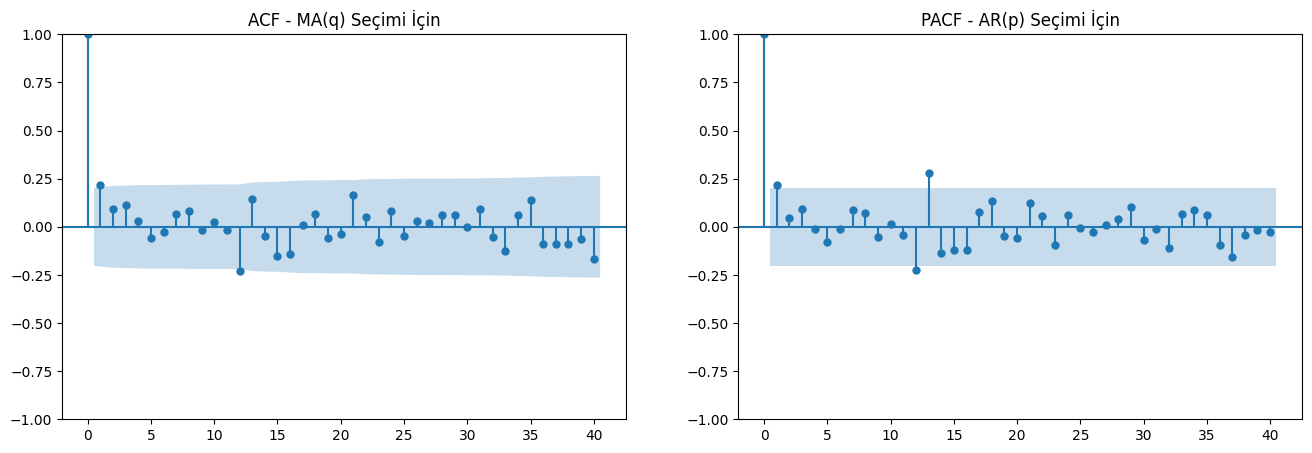

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# İki grafiği yan yana çizmek için alan oluşturma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# ACF grafiği (MA - q)
plot_acf(df_diff, lags=40, ax=ax1)
ax1.set_title("ACF - MA(q) Seçimi İçin")

# PACF grafiği (AR - p)
plot_pacf(df_diff, lags=40, ax=ax2)
ax2.set_title("PACF - AR(p) Seçimi İçin")

plt.show()

☝️ ACF veya PACF'de anlamlı pik yok gibi görünüyor, bu yüzden büyük olasılıkla p=q=0.
SARIMA için ilk tahminimiz bu nedenle d=0, p=q=0, D=1 ve m=12.

P ve Q değerlerini nasıl bulacağız? Burada, `pdarima`'nın bizim için grid_search ile P ve Q için 1 ve 0 değerlerini denemesine izin vereceğiz.
Bu katsayıları kendiniz bulmak istiyorsanız, bazı pratik kurallar için [bunu okuyun](https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/)

👉 Eğitim seti için [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) çalıştırın. seasonal=True, m=12 ve D=1 ayarlayın. p ve q, P ve Q'yu 0'dan 2'ye kadar arayın. Ardından model.summary() ile modelin özetini yazdırın.
`njobs=-1, trace=True, error_action='ignore', suppress_warnings=True` kullanın

In [ ]:
import pmdarima as pm

# p, q, P, Q değerlerini otomatik bulmak için auto_arima'yı çalıştırıyorum
# d=0 ve D=1 olduğunu manuel olarak kesinleştirdiğimiz için bunları sabit tutuyoruz
model = pm.auto_arima(df_train,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      seasonal=True, m=12,
                      d=0, D=1,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      njobs=-1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

# Modelin özeti
print(model.summary())

/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.08 sec


/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.20 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.04 sec


/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.567 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -475.126
Date:                  Thu, 12 Feb 2026   AIC                            954.252
Time:                          16:16:44   BIC                            958.441
Sample:                      01-01-1964   HQIC                           955.891
                           - 12-01-1969                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    447.0500     87.035      5.136      0

Bulunan en iyi model `ARIMA(0,0,0)(0,1,0)[12]`!
Bu, düşünülen zaman serisinin basit "mevsimsel farklaştırma"nın ötesinde herhangi bir "oto-regresif" veya "hareketli ortalama" modelleme eklemeyi haklı çıkarmadığı anlamına gelir.

Böyle "zayıf" bir model muhtemelen sadece tespit edilen son mevsimsel desenin tekrarını ve ortalama artan trendin uzatılmasını tahmin edecektir. Kontrol edelim

👉 Aşağıdaki üç tahmini kaydetmek için `n_periods` = test setinin uzunluğu ile `model.predict` kullanın
- `central`
- `upper`
- `lower`

Bunları Pandas Series olarak kaydedin ve `y_test`inizle aynı indeks ile indeksleyin

In [15]:
# Test setinin uzunluğu kadar tahmin yapar
n_periods = len(df_test)

# Tahminleri ve güven aralıklarını alma
central, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Güven aralıklarını alt ve üst olarak ayırma
lower = conf_int[:, 0]
upper = conf_int[:, 1]

# Hepsini orijinal test setinin indeksiyle (tarihlerle) Pandas Series yapma
central = pd.Series(central, index=df_test.index)
lower = pd.Series(lower, index=df_test.index)
upper = pd.Series(upper, index=df_test.index)

/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


👇 Tahminlerinizi gerçeklikle karşılaştırmak için aşağıdaki hücreyi çalıştırın

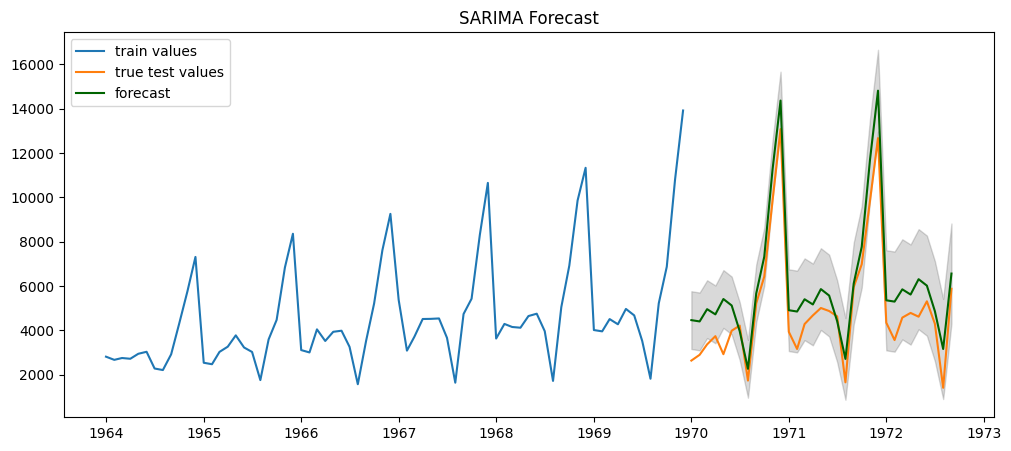

In [16]:
# Plot
plt.figure(figsize=(12, 5), dpi=100)

plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")

plt.fill_between(
    lower.index,
    lower,
    upper,
    color='k', alpha=.15
)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 SARIMA'nızda `p`, `d`, `P`, `D`'ye null olmayan değerler atamayı deneyin ve etkileri karşılaştırmak için bu grafiği yeniden çizin!

/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66952D+00    |proj g|=  2.15353D-01

At iterate    5    f=  6.57381D+00    |proj g|=  2.13065D-02

At iterate   10    f=  6.55545D+00    |proj g|=  6.58852D-03

At iterate   15    f=  6.55318D+00    |proj g|=  6.90646D-04

At iterate   20    f=  6.55282D+00    |proj g|=  1.35611D-03

At iterate   25    f=  6.55055D+00    |proj g|=  2.32431D-02

At iterate   30    f=  6.53699D+00    |proj g|=  7.24776D-03

At iterate   35    f=  6.53570D+00    |proj g|=  2.23367D-03

At iterate   40    f=  6.53041D+00    |proj g|=  2.09428D-02

At iterate   45    f=  6.52925D+00    |proj g|=  3.57385D-04

At iterate   50    f=  6.52920D+00    |proj g|=  2.82894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cevdetkopuz/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


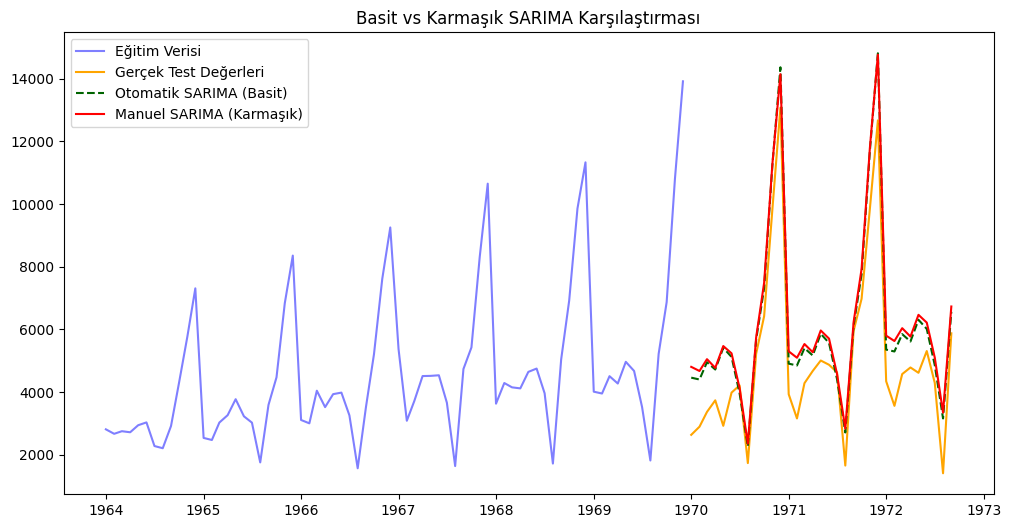

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# d=1 (normal fark) ve p=1, P=1
# Bu sefer auto_arima değil, doğrudan statsmodels kullanıyorum
manual_model = SARIMAX(df_train,
                       order=(1, 1, 1),              # p, d, q
                       seasonal_order=(1, 1, 1, 12)) # P, D, Q, m
manual_results = manual_model.fit()

# Yeni tahminleri üretme
n_periods = len(df_test)
manual_forecast = manual_results.get_forecast(steps=n_periods)
manual_central = manual_forecast.predicted_mean
manual_conf_int = manual_forecast.conf_int()

# Pandas Series formatına çevirme
manual_central.index = df_test.index

plt.figure(figsize=(12, 6))

# Gerçek değerler
plt.plot(df_train, label="Eğitim Verisi", color="blue", alpha=0.5)
plt.plot(df_test, label="Gerçek Test Değerleri", color="orange")

# İlk (Otomatik) Modelin Tahmini (Eski 'central' değişkenin)
plt.plot(central, label="Otomatik SARIMA (Basit)", color="darkgreen", linestyle="--")

# Yeni (Manuel) Modelin Tahmini
plt.plot(manual_central, label="Manuel SARIMA (Karmaşık)", color="red")

plt.title("Basit vs Karmaşık SARIMA Karşılaştırması")
plt.legend()
plt.show()

# İSTEĞE BAĞLI - Makine Öğrenmesi Yaklaşımı

### Sadece 1 aylık tahmin ufku olan model

Şimdi Random Forest gibi doğrusal olmayan bir model uyduruyoruz. Fikir, son değerlerden bir değer tahmin etmektir.

👉 `df`'de `df['Sales']`'ın kaydırılmış versiyonu olan yeni sütunlar oluşturun. Bunu 1'den 12'ye kadar kaydırma ile yapın.

In [18]:
# 1'den 12'ye kadar gecikmeli sütunlar oluşturma
for i in range(1, 13):
    df[f'lag_{i}'] = df['Sales'].shift(i)

# NaN temizleme
df.dropna(inplace=True)

df.head()

,Sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Month,,,,,,,,,,,,,
1965-01-01,2541,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0
1965-02-01,2475,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0
1965-03-01,3031,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0
1965-04-01,3266,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0
1965-05-01,3776,3266.0,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0


👉 Kaydırılmış özelliklerinize dayalı olarak Satışları tahmin etmek için bir `random forest` algoritması oluşturun (eğitmeyin)

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Modeli tanımlayalım (henüz eğitmiyoruz)
# n_estimators=100: 100 farklı karar ağacı kullan demek
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Özelliklerimizi (X) ve hedefimizi (y) belirledik
# lag_1'den lag_12'ye kadar olan sütunlar bizim girdilerimiz
features = [f'lag_{i}' for i in range(1, 13)]
X = df[features].values
y = df['Sales'].values

👉 Test etmek için aşağıdaki fonksiyonu kullanabilirsiniz. Gerçek y değerlerini (`data` NumPy array olmalı), test örneklerinin indekslerini (`test_indexes`), tahmin ediciyi (`predictor`: random forest algoritmanız) ve kaydırılmış sütunları (`full_X` NumPy array olmalı) alır.

In [27]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0

    for _index in test_indexes:
        train_data = y_true[:_index]
        current_ground_truth = y_true[_index]
        current_ground_truth_features = full_X[_index,:]
        train_features = full_X[:_index]

        # train the model on all data points until (t-1) to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

        i += 1

    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))

    return ground_truth, predictions, mape

In [29]:
import numpy as np

In [30]:
# 1. Modeli, özellikleri (X) ve hedefi (y) belirleyelim
# lag_1'den lag_12'ye kadar oluşturduğun sütunları kullanıyoruz
features = [f'lag_{i}' for i in range(1, 13)]
X_ml = df[features].values
y_ml = df['Sales'].values

# 2. Test setinin başladığı indeksi belirleyelim (1970'ten sonrası)
# Not: df_train'in uzunluğu kadar veriyi eğitim için ayırıyoruz
test_indexes = range(len(df_train), len(df))

# 3. Fonksiyonu çalıştıralım (rf_model'i bir önceki adımda tanımlamıştın)
ground_truth, predictions, mape = evaluate_performance_month_prediction(y_ml, test_indexes, model_rf, X_ml)

# 4. Sonucu ekrana yazdıralım
print(f"Random Forest (Gecikmeli Özellikler) MAPE Skoru: %{mape * 100:.2f}")

Random Forest (Gecikmeli Özellikler) MAPE Skoru: %13.04


Modelimizi iyileştirmek için özellik mühendisliği yapabiliriz. Random forest'ı eğitmek için kullanılan verilere hareketli ortalamalar ekleyeceksiniz.

`df`'de 3 yeni sütun oluşturmayı deneyin: biri 12 pencereli `df[Sales]`'ın hareketli ortalaması, biri 3 pencereli ve biri 2 pencereli. Bu, trendi izole etme ve algoritmanın öğrenmesine izin verme etkisine sahip olacaktır. Bu verileri çizin.


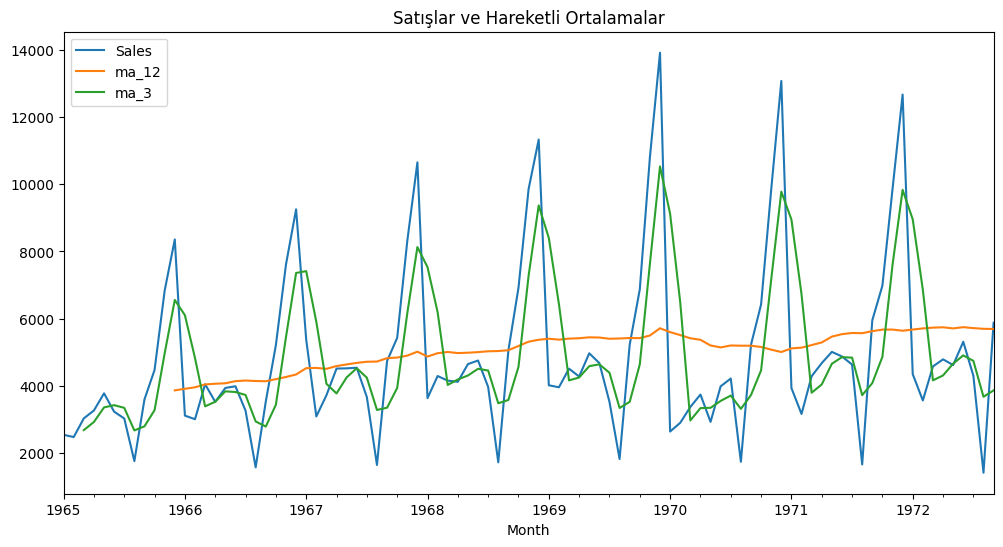

In [31]:
# 12, 3 ve 2 aylık pencerelerle hareketli ortalama ekleyelim
df['ma_12'] = df['Sales'].rolling(window=12).mean()
df['ma_3'] = df['Sales'].rolling(window=3).mean()
df['ma_2'] = df['Sales'].rolling(window=2).mean()

# Trendleri görselleştirelim
df[['Sales', 'ma_12', 'ma_3']].plot(figsize=(12, 6))
plt.title("Satışlar ve Hareketli Ortalamalar")
plt.show()

İstatistiksel olarak bir AR sürecini optimize eden üstel hareketli ortalama kullanarak daha güçlü bir yumuşatma tahmincisi de ekleyebilirsiniz (ipucu: 2, 3 ve 12 `halflife` ile `.ewm` metodu). Bu verileri çizin.

In [33]:
# 2, 3 ve 12 periyotluk üstel ortalamalar ekleyelim
for h in [2, 3, 12]:
    df[f'ewm_{h}'] = df['Sales'].ewm(halflife=h).mean()

# Yeni sütunlar nedeniyle oluşan boş (NaN) satırları temizleyelim
df.dropna(inplace=True)

Daha iyi bir MAPE görmelisiniz!

Her özelliğin önemine bakmayı deneyin. Ne buluyorsunuz?


In [35]:
# Tüm sütunları (Sales hariç) özellik olarak alalım
new_features = [col for col in df.columns if col not in ['Sales', 'Month']]
X_new = df[new_features].values
y_new = df['Sales'].values

# Test başlangıcını belirle (1970 ve sonrası)
test_indexes_new = range(len(df_train) - 12, len(y_new)) # Kaydırmalar sonrası indeksi ayarlıyoruz

# Performansı ölçelim
ground_truth, predictions, mape_new = evaluate_performance_month_prediction(y_new, test_indexes_new, model_rf, X_new)

print(f"Yeni (Gelişmiş) MAPE Skoru: %{mape_new * 100:.2f}")

Yeni (Gelişmiş) MAPE Skoru: %14.52


### Örneklem-Dışı Tahmin Modelleri

Şimdi "örneklem-dışı" tahminde SARIMA'yı geçmeyi deneyelim.

👉 _Her tahmin ufku için bir model eğitin_ (`1`-aylık ufuktan `len(y_test)` aya kadar)
👉 MAPE'yi değerlendirin ve SARIMA ile karşılaştırın

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# 1. SARIMA MAPE (central tahminlerinle df_test arasındaki fark)
sarima_mape = mean_absolute_percentage_error(df_test, central)

# 2. Random Forest Dinamik Tahmin Döngüsü (Hata Giderilmiş Versiyon)
ml_forecasts = []
n_test = len(df_test)
n_total = len(X_new)

# Test setine karşılık gelen son n_test kadar veriyi tahmin etme
for i in range(n_test):
    # Eğitim verisi: Mevcut test adımına kadar olan tüm geçmiş
    current_train_end = n_total - n_test + i
    X_train_dynamic = X_new[:current_train_end]
    y_train_dynamic = y_new[:current_train_end]

    # Modeli eğit
    model_rf.fit(X_train_dynamic, y_train_dynamic)

    # Bir sonraki (i. sıradaki) test örneğini tahmin et
    next_feature = X_new[current_train_end].reshape(1, -1)
    ml_forecasts.append(model_rf.predict(next_feature)[0])

# 3. Skorları Hesapla
ml_mape = mean_absolute_percentage_error(df_test, ml_forecasts)

print(f"--- FİNAL DÜELLO SONUÇLARI ---")
print(f"SARIMA MAPE Skoru        : %{sarima_mape * 100:.2f}")
print(f"Random Forest (Dinamik)  : %{ml_mape * 100:.2f}")

--- FİNAL DÜELLO SONUÇLARI ---
SARIMA MAPE Skoru        : %29.42
Random Forest (Dinamik)  : %17.50
